In [1]:
import sys
import os
from dotenv import load_dotenv

import numpy as np
import pandas as pd
import sqlalchemy as sq
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

import tensorflow
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

sys.path.append("../Shared/")
from DataService import DataService

2023-07-02 17:32:41.517696: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-02 17:32:42.046556: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# fetch data from db

In [2]:
# function to update logs
def updateLog(fileName: str, message: str) -> None:
    try:
        if fileName is not None:
            with open(fileName, "a") as log:
                log.write(message + "\n")
    except Exception as e:
        print(message)

In [3]:
LOG_FILE = "/data/pull_moisture.log"

load_dotenv()
PG_USER = os.getenv("POSTGRES_USER")
PG_PW = os.getenv("POSTGRES_PW")
PG_DB = os.getenv("POSTGRES_DB")
PG_ADDR = os.getenv("POSTGRES_ADDR")
PG_PORT = os.getenv("POSTGRES_PORT")

In [4]:
if (
    PG_DB is None
    or PG_ADDR is None
    or PG_PORT is None
    or PG_USER is None
    or PG_PW is None
):
    updateLog(LOG_FILE, "Missing database credentials")
    raise ValueError("Environment variables are not set")
else:
    # connicting to database
    db = DataService(PG_DB, PG_ADDR, int(PG_PORT), PG_USER, PG_PW)
    conn = db.connect()

In [5]:
# pulling soil moisture data
query = sq.text("select * FROM public.agg_soil_moisture")
sm_df = pd.read_sql(query, conn)

In [6]:
sm_df.drop(columns=["index"], inplace=True)
sm_df.head()

,year,month,day,cr_num,district,soil_moisture_min,soil_moisture_max,soil_moisture_mean
0,1978,11,1,0,4612,0.165900,0.418710,0.237053
1,1978,11,1,5,4740,0.127140,0.207248,0.163722
2,1978,11,1,5,4741,0.153398,0.215304,0.170989
3,1978,11,1,7,4770,0.140772,0.186390,0.152211
4,1978,11,1,7,4771,0.116810,0.116810,0.116810


In [7]:
# pull ergot data
query = sq.text("select * FROM public.agg_ergot_samples")
ergot_df = pd.read_sql(query, conn)

In [8]:
ergot_df.shape

(158689, 18)

In [9]:
ergot_df.drop(columns=["sample_id"], inplace=True)

In [10]:
ergot_df = ergot_df.drop_duplicates()

In [11]:
ergot_df

,year,province,crop_district,incidence,severity,district,percnt_true,has_ergot,sum_severity,present_prev1,present_prev2,present_prev3,present_in_neighbor,severity_prev1,severity_prev2,severity_prev3,severity_in_neighbor
0,1995,AB,1,False,0.000,4810,0.000000,False,0.000,False,False,False,False,0.000000,0.000000,0.000000,0.000000
48,1995,AB,2,False,0.000,4820,0.000000,False,0.000,False,False,False,True,0.000000,0.000000,0.000000,0.005747
190,1995,AB,3,False,0.000,4830,0.010582,True,11.000,False,False,False,True,0.000000,0.000000,0.000000,0.001817
230,1995,AB,4,False,0.000,4840,0.006017,True,15.000,False,False,False,False,0.000000,0.000000,0.000000,0.000000
280,1995,AB,4,True,1.000,4840,0.006017,True,15.000,False,False,False,False,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158540,2022,AB,3,True,0.260,4830,0.419355,True,1.270,True,True,True,True,0.025641,0.513369,0.083333,0.279330
158636,2022,SK,72,True,0.025,4771,0.333333,True,0.726,False,True,True,True,0.000000,0.153333,0.013072,0.366292
158655,2022,MB,3,True,0.000,4603,0.535354,True,1.360,False,True,True,True,0.000000,0.309353,0.043165,0.487047
158660,2022,SK,41,True,0.010,4740,0.111111,True,0.010,False,False,False,True,0.000000,0.000000,0.000000,0.162162


In [12]:
# pull weather data
# in case reading csv
weather_df = pd.read_csv("data/aggregatedDly.csv")
weather_df.shape

(1064, 5478)

In [13]:
weather_df

,Unnamed: 0,year,district,01-01:max_temp,01-01:min_temp,01-01:mean_temp,01-01:min_total_rain,01-01:max_total_rain,01-01:mean_total_rain,01-01:min_total_snow,...,12-31:mean_total_rain,12-31:min_total_snow,12-31:max_total_snow,12-31:mean_total_snow,12-31:min_total_precip,12-31:max_total_precip,12-31:mean_total_precip,12-31:min_snow_on_grnd,12-31:max_snow_on_grnd,12-31:mean_snow_on_grnd
0,0,1995,4860,-8.0375,-20.200000,-14.137500,0.0,0.0,0.0,0.0,...,0.0,0.0,7.3,1.70,0.0,1.5,0.444444,0.0,36.0,16.333333
1,1,1995,4810,-7.4200,-17.000000,-12.220000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.000000,0.0,19.0,6.600000
2,2,1995,4840,-8.3000,-19.425000,-13.875000,0.0,0.0,0.0,0.0,...,0.0,0.0,2.9,1.52,0.0,7.7,2.280000,0.0,24.0,8.800000
3,3,1995,4830,-5.7500,-20.258333,-13.033333,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,5.1,0.392308,0.0,28.0,5.615385
4,4,1995,4731,-7.3000,-19.650000,-13.500000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.000000,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1059,1059,2022,4605,-28.3000,-33.000000,-30.700000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.000000,27.0,27.0,27.000000
1060,1060,2022,4720,-24.8000,-36.900000,-30.850000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.1,0.050000,23.0,34.0,28.500000
1061,1061,2022,4611,-25.8000,-35.600000,-30.700000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.1,0.1,0.100000,14.0,14.0,14.000000
1062,1062,2022,4751,-22.9000,-33.600000,-28.300000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.000000,6.0,6.0,6.000000


In [14]:
weather_df.drop(weather_df.columns[0], axis=1, inplace=True)

In [15]:
all_col = weather_df.columns.tolist()
uni_col = set()
for i in range (2,len(all_col)):
    # print(all_col[i].split(":")[1])
    uni_col.add(all_col[i].split(":")[1])

In [ ]:
uni_col

In [16]:
for col_name in uni_col:
    # col_name = "max_temp"
    fil_col = weather_df.filter(like=col_name)
    weather_df[col_name] = fil_col.mean(axis=1)
    weather_df.drop(columns=fil_col.columns, inplace=True)

In [17]:
weather_df

,year,district,min_total_rain,min_temp,max_snow_on_grnd,min_total_snow,max_total_snow,mean_snow_on_grnd,max_temp,min_snow_on_grnd,min_total_precip,mean_total_precip,mean_total_snow,mean_total_rain,max_total_precip,mean_temp,max_total_rain
0,1995,4860,0.00000,-5.342542,14.356164,0.000000,1.438356,6.005903,6.238637,0.000000,0.009589,1.189348,0.303979,0.529384,4.561918,0.451735,2.608767
1,1995,4810,0.00000,-2.249689,2.334247,0.000000,0.416438,0.860822,10.713096,0.000000,0.049589,0.871078,0.116534,0.328105,2.528767,4.239744,1.224110
2,1995,4840,0.00000,-4.348895,7.876712,0.000000,0.565479,3.564932,7.595941,0.175342,0.064110,0.790694,0.155237,0.250507,2.203836,1.628772,1.018630
3,1995,4830,0.00000,-3.321827,6.394521,0.000000,1.108219,1.054999,9.424064,0.000000,0.001918,1.299196,0.135583,0.332711,5.339178,3.060292,2.089863
4,1995,4731,0.00274,-2.909954,0.019178,0.005479,0.016438,0.010959,8.491324,0.002740,0.618356,0.908037,0.010502,0.078265,1.211233,2.796575,0.157260
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1059,2022,4605,0.00000,-4.997808,14.356164,0.000000,0.000000,14.356164,6.552603,14.356164,1.151507,1.151507,0.000000,0.000000,1.151507,0.777808,0.000000
1060,2022,4720,0.00000,-3.850137,8.556164,0.000000,0.000000,6.519178,9.157397,4.482192,0.786027,1.097808,0.000000,0.000000,1.409589,2.653288,0.000000
1061,2022,4611,0.00000,-3.437808,5.945205,0.000000,0.000000,5.945205,7.302466,5.945205,2.099726,2.099726,0.000000,0.000000,2.099726,1.931507,0.000000
1062,2022,4751,0.00000,-3.926301,5.210959,0.000000,0.000000,5.210959,6.706301,5.210959,1.102466,1.102466,0.000000,0.000000,1.102466,1.386849,0.000000


In [23]:
# joining tables
# df = pd.merge(sm_df, ergot_df, how="inner", on=["year", "district"])
df = pd.merge(sm_df, ergot_df)

In [24]:
df.shape

(353355, 23)

In [25]:
df = pd.merge(df, weather_df, on=["year", "district"])

In [26]:
df.shape

(348520, 38)

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 348520 entries, 0 to 348519
Data columns (total 38 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   year                  348520 non-null  int64  
 1   month                 348520 non-null  int64  
 2   day                   348520 non-null  int64  
 3   cr_num                348520 non-null  int64  
 4   district              348520 non-null  int64  
 5   soil_moisture_min     348520 non-null  float64
 6   soil_moisture_max     348520 non-null  float64
 7   soil_moisture_mean    348520 non-null  float64
 8   province              348520 non-null  object 
 9   crop_district         348520 non-null  int64  
 10  incidence             348520 non-null  bool   
 11  severity              348520 non-null  float64
 12  percnt_true           348520 non-null  float64
 13  has_ergot             348520 non-null  bool   
 14  sum_severity          348520 non-null  float64
 15  

In [ ]:
df

In [ ]:
df.to_csv("data/temp.csv")

In [ ]:
# temp = pd.merge(ergot_df, weather_df)
# temp.columns

In [ ]:
# g = sns.pairplot(temp.sample(1000))

/tmp/ipykernel_268927/3641604358.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


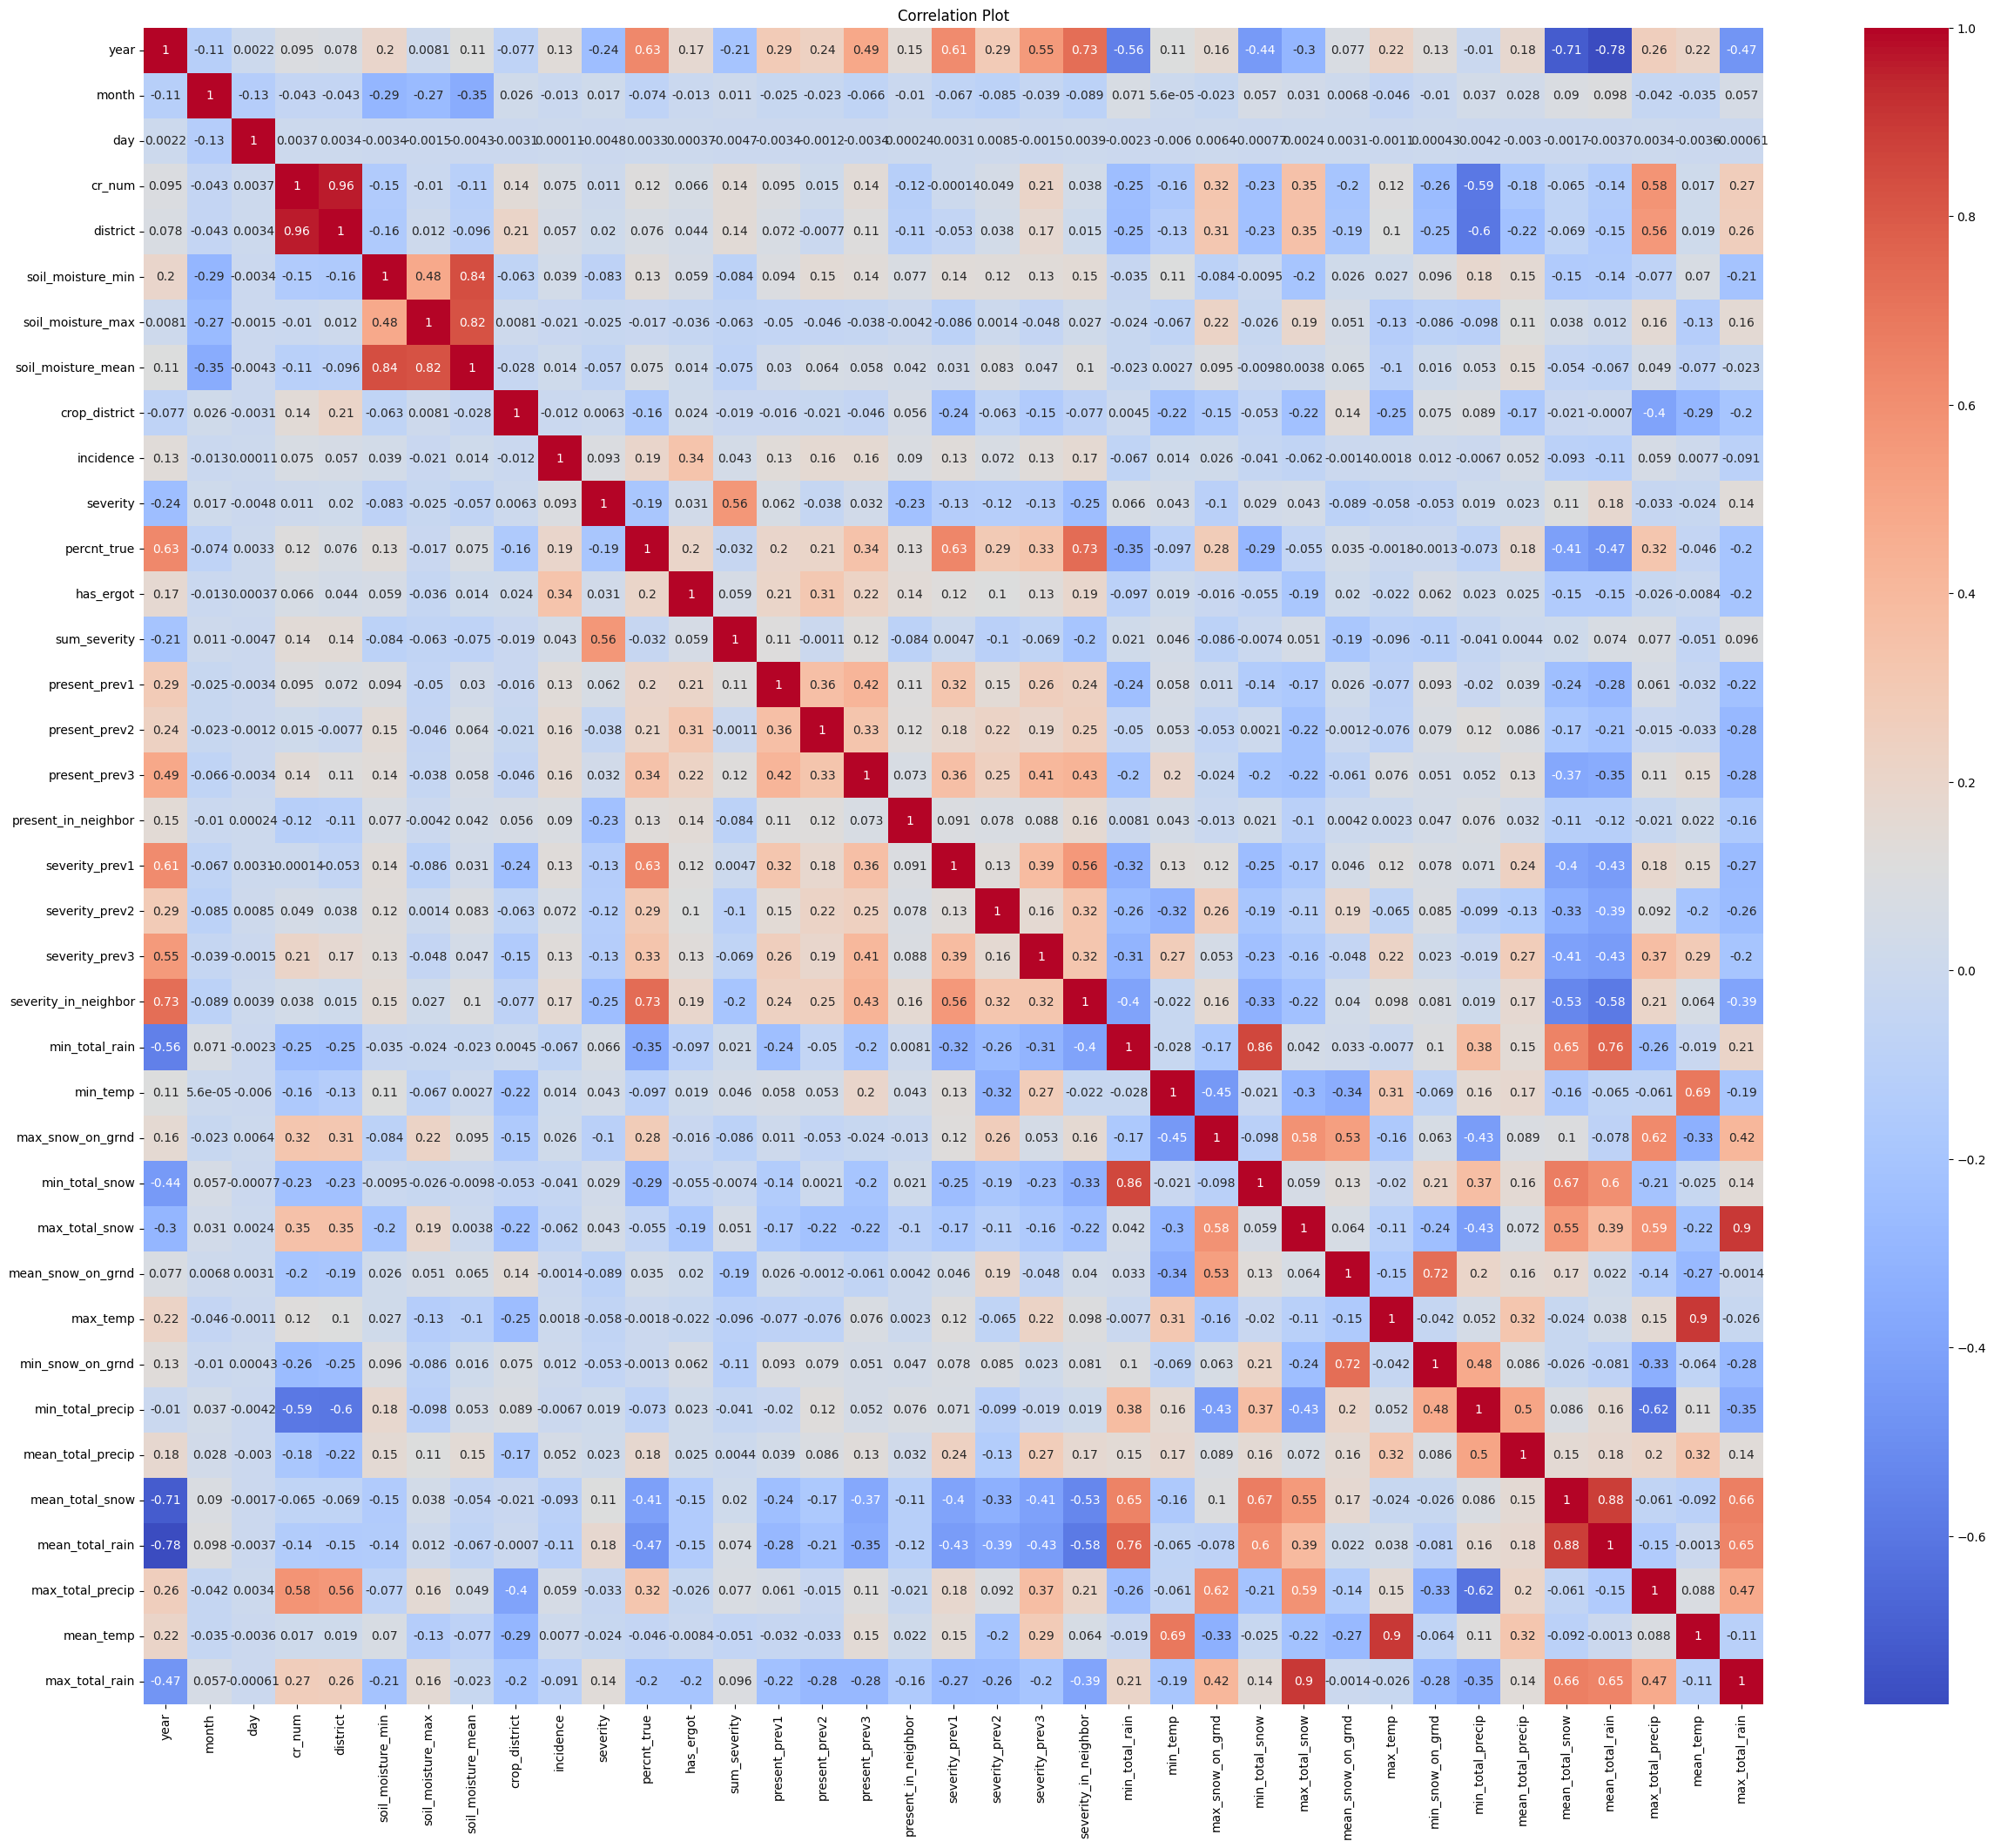

In [28]:
correlation_matrix = df.corr()
# Plot the correlation matrix as a heatmap
plt.figure(figsize=(30, 25))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=True)
plt.title('Correlation Plot')
plt.show()

In [29]:
# with the following function we can select highly correlated features
# it will remove the first feature that is correlated with anything other feature

def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

In [31]:
corr_features = correlation(df, 0.8)
len(set(corr_features))
corr_features

/tmp/ipykernel_268927/3726835926.py:6: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = dataset.corr()


{'district',
 'max_total_rain',
 'mean_temp',
 'mean_total_rain',
 'min_total_snow',
 'soil_moisture_mean'}

In [33]:
df.drop(columns=corr_features, inplace=True)

In [ ]:
# using one hot encoding to change catagorical variable to numarical
df = pd.get_dummies(df, columns=["province"], drop_first=True)

In [42]:
df

,year,month,day,cr_num,soil_moisture_min,soil_moisture_max,crop_district,incidence,severity,percnt_true,...,max_total_snow,mean_snow_on_grnd,max_temp,min_snow_on_grnd,min_total_precip,mean_total_precip,mean_total_snow,max_total_precip,province_MB,province_SK
0,1997,1,2,5,0.154430,0.154430,42,False,0.00,0.000000,...,0.001096,0.000000,10.781644,0.000000,0.574795,0.574795,0.001096,0.574795,0,1
1,1997,3,21,5,0.160740,0.206815,42,False,0.00,0.000000,...,0.001096,0.000000,10.781644,0.000000,0.574795,0.574795,0.001096,0.574795,0,1
2,1997,3,26,5,0.169883,0.237919,42,False,0.00,0.000000,...,0.001096,0.000000,10.781644,0.000000,0.574795,0.574795,0.001096,0.574795,0,1
3,1997,3,28,5,0.239734,0.264594,42,False,0.00,0.000000,...,0.001096,0.000000,10.781644,0.000000,0.574795,0.574795,0.001096,0.574795,0,1
4,1997,3,29,5,0.252850,0.273013,42,False,0.00,0.000000,...,0.001096,0.000000,10.781644,0.000000,0.574795,0.574795,0.001096,0.574795,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
348515,2017,10,30,2,0.227539,0.269473,5,True,0.00,0.347826,...,0.000000,2.961644,8.341370,2.961644,0.849589,0.849589,0.000000,0.849589,1,0
348516,2017,10,30,2,0.227539,0.269473,5,False,0.00,0.347826,...,0.000000,2.961644,8.341370,2.961644,0.849589,0.849589,0.000000,0.849589,1,0
348517,2017,10,30,2,0.227539,0.269473,5,True,0.02,0.347826,...,0.000000,2.961644,8.341370,2.961644,0.849589,0.849589,0.000000,0.849589,1,0
348518,2017,10,30,2,0.227539,0.269473,5,True,0.01,0.347826,...,0.000000,2.961644,8.341370,2.961644,0.849589,0.849589,0.000000,0.849589,1,0


# split data

In [61]:
X = df.drop(columns=["has_ergot"])
y = df['has_ergot']
# y = df['has_ergot'].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=1, stratify=y)

In [62]:
# use StandardScaler when we don't know upper bounds
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [63]:
X_train_scaled.shape

(243964, 32)

In [64]:
tensorflow.config.set_visible_devices([], 'GPU')  # Hide GPU devices
tensorflow.config.set_visible_devices(tensorflow.config.list_physical_devices('CPU'), 'CPU')  # Show CPU devices


# creating model

In [65]:
model = Sequential()

model.add(Dense(10, activation="relu", input_dim = X.shape[1]))
# model.add(Dense(32, activation="relu"))
model.add(Dense(1, activation="sigmoid"))

In [66]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 10)                330       
                                                                 
 dense_5 (Dense)             (None, 1)                 11        
                                                                 
Total params: 341
Trainable params: 341
Non-trainable params: 0
_________________________________________________________________


In [67]:
# compile model
model.compile(loss="binary_crossentropy", optimizer="Adam", metrics=["accuracy"])

In [68]:
history = model.fit(X_train_scaled, y_train, epochs=10, validation_split=0.2, shuffle=True, batch_size=32)

Epoch 1/10


6100/6100 [==============================] - 6s 898us/step - loss: 0.0629 - accuracy: 0.9778 - val_loss: 0.0139 - val_accuracy: 0.9969
Epoch 2/10
6100/6100 [==============================] - 5s 888us/step - loss: 0.0078 - accuracy: 0.9991 - val_loss: 0.0034 - val_accuracy: 1.0000
Epoch 3/10
6100/6100 [==============================] - 5s 881us/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 9.7189e-04 - val_accuracy: 1.0000
Epoch 4/10
6100/6100 [==============================] - 5s 876us/step - loss: 4.4721e-04 - accuracy: 1.0000 - val_loss: 1.8299e-04 - val_accuracy: 1.0000
Epoch 5/10
6100/6100 [==============================] - 5s 895us/step - loss: 8.9080e-05 - accuracy: 1.0000 - val_loss: 2.9218e-05 - val_accuracy: 1.0000
Epoch 6/10
6100/6100 [==============================] - 5s 893us/step - loss: 1.7336e-05 - accuracy: 1.0000 - val_loss: 6.5842e-06 - val_accuracy: 1.0000
Epoch 7/10
6100/6100 [==============================] - 6s 903us/step - loss: 3.5321e-06 - accuracy: 1.0000

In [69]:
y_pred = model.predict(X_test_scaled)

3268/3268 [==============================] - 1s 439us/step


In [70]:
threshhold = 0.7
y_pred = np.where(y_pred > threshhold, True, False)

# y_test = y_test.to_numpy()
# type(y_pred)

In [71]:
accuracy_score(y_test, y_pred)

1.0

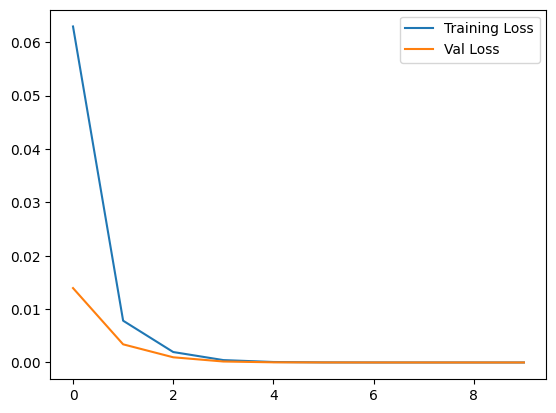

In [72]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.legend()

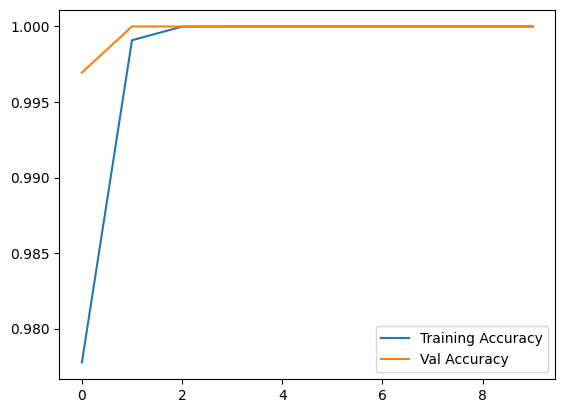

In [73]:
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Val Accuracy")
plt.legend()